## Data Mining project: Discover and describe areas of interest an events from geo-located data

## Task #1: Import Dataset and Librarie

## Library Installation

In [1]:
# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
! pip install scipy==1.12.0
# plotting 
! pip install plotly==5.24.1 
! pip install matplotlib==3.8.0 
! pip install seaborn==0.13.2 
! pip install plotly-express==0.4.1 
! pip install chart-studio==1.1.0 
# web app library 
! pip install streamlit==1.37.1 
# association rules
! pip install mlxtend==0.23.3 
! pip install folium==0.19.4
! pip install geopy==2.4.1
! pip install pyproj
# text mining
! pip install nltk==3.6.5
! pip install wordcloud
! pip install pillow==9.5.0
! pip install osmnx


## Import

In [2]:
# load pandas to deal with the data
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from geopy.distance import geodesic
from scipy.spatial import ConvexHull, QhullError

from sklearn.cluster import AgglomerativeClustering,  DBSCAN  ,linkage_tree  
from scipy.cluster.hierarchy import dendrogram
import folium
import seaborn as sns
import random
from scipy.spatial.distance import cdist
from itertools import permutations
import osmnx as ox
import networkx as nx

# Data cleaning and preparation

In [3]:
# Charger le fichier CSV
data = pd.read_csv("../data/dataset.csv", sep=",", low_memory=False)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420240 entries, 0 to 420239
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   420240 non-null  int64  
 1    user                420240 non-null  object 
 2    lat                 420240 non-null  float64
 3    long                420240 non-null  float64
 4    tags                316730 non-null  object 
 5    title               381911 non-null  object 
 6    date_taken_minute   420239 non-null  float64
 7    date_taken_hour     420240 non-null  int64  
 8    date_taken_day      420240 non-null  int64  
 9    date_taken_month    420240 non-null  int64  
 10   date_taken_year     420240 non-null  int64  
 11   date_upload_minute  420228 non-null  object 
 12   date_upload_hour    420238 non-null  object 
 13   date_upload_day     420238 non-null  float64
 14   date_upload_month   420240 non-null  int64  
 15   date_upload_year

### Type Conversion

In [4]:
# Sélectionner les colonnes 11 et 12 (indices 10 et 11 en pandas)
columns_to_check = data.iloc[:, [11, 12]]

# Parcourir chaque colonne sélectionnée
for col in columns_to_check.columns:
    print(f"Analyse de la colonne: {col}")
    
    # Trouver les types de données présents
    types_present = data[col].map(type).value_counts()
    print("Types présents dans cette colonne :")
    print(types_present)
    
    # Afficher l'utilisation de la mémoire pour cette colonne
    memory_usage = data[col].memory_usage(deep=True)
    print(f"Utilisation de la mémoire pour cette colonne : {memory_usage} bytes\n")

for col in columns_to_check.columns:
    print(f"Conversion de la colonne: {col}")
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0)  # Convertir en float, remplacer les erreurs par NaN

    # Vérifier le résultat
    print(f"Colonne {col} après conversion:")
    print(data[col].head())  # Afficher les premières lignes pour valider
    print(f"Types après conversion: {data[col].map(type).value_counts()}\n")

Analyse de la colonne:  date_upload_minute
Types présents dans cette colonne :
 date_upload_minute
<class 'str'>      420228
<class 'float'>        12
Name: count, dtype: int64
Utilisation de la mémoire pour cette colonne : 21366572 bytes

Analyse de la colonne:  date_upload_hour
Types présents dans cette colonne :
 date_upload_hour
<class 'str'>      420238
<class 'float'>         2
Name: count, dtype: int64
Utilisation de la mémoire pour cette colonne : 21349400 bytes

Conversion de la colonne:  date_upload_minute
Colonne  date_upload_minute après conversion:
0    23.0
1    52.0
2    33.0
3    38.0
4    38.0
Name:  date_upload_minute, dtype: float64
Types après conversion:  date_upload_minute
<class 'float'>    420240
Name: count, dtype: int64

Conversion de la colonne:  date_upload_hour
Colonne  date_upload_hour après conversion:
0    20.0
1    17.0
2    17.0
3    12.0
4    12.0
Name:  date_upload_hour, dtype: float64
Types après conversion:  date_upload_hour
<class 'float'>    4202

In [5]:
#rename columms
data.columns = data.columns.str.strip()
print("Colonnes après nettoyage :", data.columns.tolist())

Colonnes après nettoyage : ['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute', 'date_taken_hour', 'date_taken_day', 'date_taken_month', 'date_taken_year', 'date_upload_minute', 'date_upload_hour', 'date_upload_day', 'date_upload_month', 'date_upload_year', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']


### NULL Values

In [6]:
#Find null values
data.isna().sum()

id                         0
user                       0
lat                        0
long                       0
tags                  103510
title                  38329
date_taken_minute          1
date_taken_hour            0
date_taken_day             0
date_taken_month           0
date_taken_year            0
date_upload_minute         0
date_upload_hour           0
date_upload_day            2
date_upload_month          0
date_upload_year           1
Unnamed: 16           420098
Unnamed: 17           420240
Unnamed: 18           420238
dtype: int64

In [7]:
print(f"Initial: {len(data)}")
print(data.columns)
columns_to_clean = [
					'lat', 'long', 'date_taken_minute', 'date_taken_hour', 
					'date_taken_day', 'date_taken_month', 'date_taken_year', 
					'date_upload_minute', 'date_upload_hour', 'date_upload_day', 
					'date_upload_month', 'date_upload_year'
					]
data_cleaned = data.dropna(subset=columns_to_clean)
print(f"After removing missing values: {len(data_cleaned)}")

Initial: 420240
Index(['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute',
       'date_taken_hour', 'date_taken_day', 'date_taken_month',
       'date_taken_year', 'date_upload_minute', 'date_upload_hour',
       'date_upload_day', 'date_upload_month', 'date_upload_year',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')
After removing missing values: 420236


### Duplicates

In [8]:
# Check if there are any duplicates
data_cleaned.duplicated().sum()

252138

In [9]:
# Remove duplicates if necessary
print(f"Initial: {len(data_cleaned)}")
data_cleaned = data_cleaned.drop_duplicates(subset=['user','lat','long','title','date_taken_year','date_taken_month','date_taken_day'],keep='first')
print(f"After removing duplicates: {len(data_cleaned)}") 

Initial: 420236
After removing duplicates: 133922


### Columns

Note that the data with a non-null values at column 16 is sorted differently. We conclude that it is hard to determine which value belongs to which column since date_taken_minute, date_taken_month can be ambigous.

In [10]:
columns = ['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']
column_data = data_cleaned.dropna(subset=columns, how='all')

print(column_data.iloc[0])

id                                                          6674970791
user                                                      29713277@N02
lat                                                          45.753948
long                                                          4.788145
tags                  portrait,throughtheleaves,autraversdesfeuillages
title                                                              NaN
date_taken_minute                                               2012.0
date_taken_hour                                                     29
date_taken_day                                                      12
date_taken_month                                                    10
date_taken_year                                                      9
date_upload_minute                                                 0.0
date_upload_hour                                                  47.0
date_upload_day                                                   21.0
date_u

The rows that have non-null values in columns 16, 17 and 18 are retracted from the dataset. These columns thus serve no purpose and are removed as well.

In [11]:
# Specify the columns to check for non-null values
columns_to_check = ['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18']

# Drop rows where any of the specified columns are not null
print(f"Initial: {len(data_cleaned)}")
data_cleaned = data_cleaned[data_cleaned[columns_to_check].isnull().all(axis=1)]
print(f"After removing non-null values: {len(data_cleaned)}")

# Drop the columns
data_cleaned = data_cleaned.drop(columns=columns)

print(data_cleaned.columns)

Initial: 133922
After removing non-null values: 133877
Index(['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute',
       'date_taken_hour', 'date_taken_day', 'date_taken_month',
       'date_taken_year', 'date_upload_minute', 'date_upload_hour',
       'date_upload_day', 'date_upload_month', 'date_upload_year'],
      dtype='object')


### Save Cleaned Data

In [12]:
data_cleaned.to_csv("../data/data-cleaned.csv", index=False)

## Descriptive Statistics

In [13]:
data_cleaned.describe(exclude=[object])

,id,lat,long,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year
count,1.338770e+05,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000,133877.000000
mean,1.923862e+10,45.768230,4.837974,29.464792,14.711885,15.154029,7.116689,2013.863442,29.468654,14.537224,15.543200,6.835580,2014.206682
std,1.368314e+10,0.028224,0.029867,17.458652,4.888294,8.741978,3.372268,3.138277,17.215056,6.555018,8.553506,3.478086,2.797429
min,3.066675e+08,45.655200,4.720312,0.000000,0.000000,1.000000,1.000000,1926.000000,0.000000,0.000000,1.000000,1.000000,2009.000000
25%,7.115050e+09,45.757697,4.826163,14.000000,12.000000,8.000000,4.000000,2012.000000,15.000000,11.000000,8.000000,4.000000,2012.000000
50%,1.482560e+10,45.763196,4.832031,30.000000,15.000000,15.000000,7.000000,2014.000000,30.000000,16.000000,15.000000,7.000000,2014.000000
75%,3.021720e+10,45.772754,4.842234,45.000000,18.000000,23.000000,10.000000,2016.000000,44.000000,20.000000,23.000000,10.000000,2017.000000
max,4.914809e+10,45.854950,5.006709,59.000000,23.000000,31.000000,12.000000,2238.000000,59.000000,23.000000,31.000000,12.000000,2019.000000


## Data Visualisation

### Geolocalisation Marker

In [14]:
m = folium.Map(location=(45.764, 4.8357), zoom_start=12)

# Sample a subset of the data (e.g., 500 points)
sampled_data = data_cleaned.sample(n=1000, random_state=1)

latitude_col = sampled_data['lat']
longitude_col = sampled_data['long']

for i in range(0, len(sampled_data)):
	folium.Marker([latitude_col.iloc[i], longitude_col.iloc[i]]).add_to(m)

m

### Geolocalisation Heatmap

In [15]:
from folium.plugins import HeatMap

m = folium.Map(location=(45.764, 4.8357), zoom_start=12)

# Sample a subset of the data (e.g., 500 points)
sampled_data = data_cleaned.sample(n=1000, random_state=1)

latitude_col = sampled_data['lat']
longitude_col = sampled_data['long']

heat_data = [[row['lat'], row['long']] for index, row in sampled_data.iterrows()]
HeatMap(heat_data).add_to(m)

m

## Clustering

### K-Means

The only data necessary to create clusters here would be the latitude and longitude. We'll drop all other columns as it is not necessary.

In [16]:
# Specify the columns to keep
columns = ['lat', 'long']

# Drop all columns except the specified ones
df_clustering = data_cleaned[columns]
print(df_clustering.head())
print(len(data_cleaned))

         lat      long
0  45.754858  4.821710
1  45.753270  4.862953
2  45.760655  4.846564
3  45.784000  4.874072
4  45.784000  4.874072
133877


Although the longitude and latitude have comparable scales, we can use the StandardScaler to normalize the data

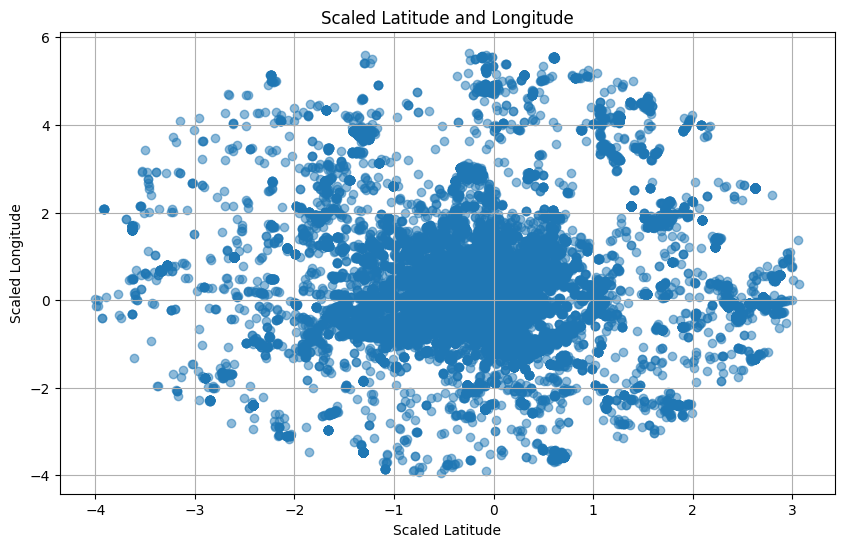

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)
scaled_data_df = pd.DataFrame(data=scaled_data, columns=df_clustering.columns)

plt.figure(figsize=(10, 6))
plt.scatter(scaled_data_df['lat'], scaled_data_df['long'], alpha=0.5)
plt.title('Scaled Latitude and Longitude')
plt.xlabel('Scaled Latitude')
plt.ylabel('Scaled Longitude')
plt.grid(True)
plt.show()

Interestingly, the same pattern observed in the heatmap is reproduced with the scaled data. This is expected, as the data has been proportionally scaled

We'll find the optimal number of clusters using Elbow method

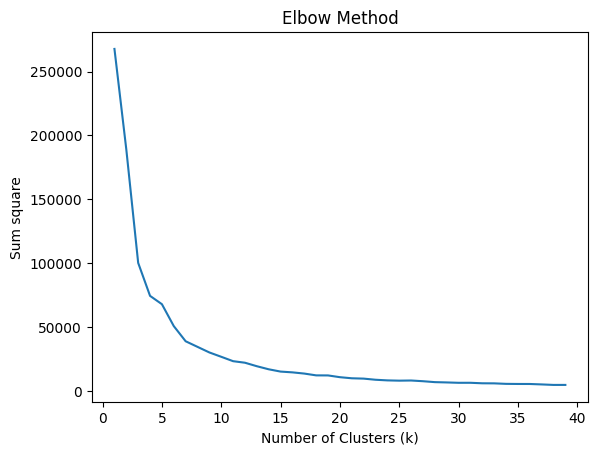

In [18]:
# Range of k values to try
k_values = range(1, 40)
sum_square = []

for k in k_values:
	kmeans = KMeans(n_clusters=k, init='k-means++')
	kmeans.fit(scaled_data_df)
	sum_square.append(kmeans.inertia_)

plt.plot(k_values, sum_square)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum square')
plt.show()


The optimal number of clusters can be interpreted to be between 6-10. We found that with 6-10 clusters, the granularity of places is not as well defined as the number of points are extremely vast and spreaded.

In [19]:
kmeans = KMeans(n_clusters=70, init='k-means++')
kmeans.fit(scaled_data_df)
data_cleaned['cluster_kmeans'] = kmeans.labels_ 
print(data_cleaned[['cluster_kmeans', 'lat', 'long']])

        cluster_kmeans        lat      long
0                   54  45.754858  4.821710
1                   63  45.753270  4.862953
2                    0  45.760655  4.846564
3                   52  45.784000  4.874072
4                   52  45.784000  4.874072
...                ...        ...       ...
413846              52  45.781863  4.875416
419007               3  45.729498  4.951550
419071               9  45.768700  4.840502
419137              48  45.771852  4.833115
420066               2  45.762044  4.821358

[133877 rows x 3 columns]


In [20]:
# Center map
m = folium.Map(location=[data_cleaned['lat'].mean(), data_cleaned['long'].mean()], zoom_start=12)

palette = sns.color_palette("hsv", n_colors=data_cleaned['cluster_kmeans'].nunique())
colors = [mcolors.rgb2hex(color) for color in palette]

centroids = scaler.inverse_transform(kmeans.cluster_centers_)
sampled_data = data_cleaned.sample(n=20000, random_state=1)
cluster_counts = sampled_data['cluster_kmeans'].value_counts()

valid_clusters = cluster_counts[cluster_counts >= 3].index.tolist()

filtered_sampled_data = sampled_data[sampled_data['cluster_kmeans'].isin(valid_clusters)]
cluster_id_sample = filtered_sampled_data['cluster_kmeans'].unique().tolist()

print(cluster_id_sample) 

# Filter points based on distance to centroids
filtered_points = filtered_sampled_data[filtered_sampled_data.apply(
    lambda row: any(geodesic((row['lat'], row['long']), centroid).m <= 300 for centroid in centroids), axis=1)]

# Map markers
for i, row in filtered_points.iterrows():
    point = (row['lat'], row['long'])
    folium.CircleMarker(
        location=point,
        radius=1,
        color=colors[row['cluster_kmeans']],
        fill=True,
        fill_color=colors[row['cluster_kmeans']]
    ).add_to(m)

# Centroids and hulls
for cluster_id in cluster_id_sample:
    cluster_points = filtered_points[filtered_points['cluster_kmeans'] == cluster_id][['lat', 'long']].values
    if len(cluster_points) >= 3:  # ConvexHull requires at least 3 points
        try: 
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            folium.Polygon(
                locations=hull_points,
                color=colors[cluster_id],
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Skipping cluster {cluster_id} due to QhullError")
    centroid = centroids[cluster_id]
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Centroid {cluster_id}',
    ).add_to(m)

m.save("../html/kmeans_map.html")

[3, 2, 0, 1, 13, 50, 7, 34, 59, 9, 35, 51, 30, 29, 6, 8, 42, 23, 65, 48, 68, 56, 5, 66, 55, 69, 54, 22, 17, 25, 39, 28, 20, 52, 32, 41, 63, 38, 19, 46, 37, 11, 62, 12, 40, 58, 4, 10, 14, 21, 24, 36, 33, 67, 57, 27, 44, 26, 15, 49, 61, 31, 18, 43, 64, 60, 16, 53, 45, 47]
Skipping cluster 5 due to QhullError
Skipping cluster 39 due to QhullError
Skipping cluster 4 due to QhullError
Skipping cluster 26 due to QhullError
Skipping cluster 15 due to QhullError
Skipping cluster 18 due to QhullError
Skipping cluster 43 due to QhullError
Skipping cluster 64 due to QhullError


### Hierarchical Clustering

133877


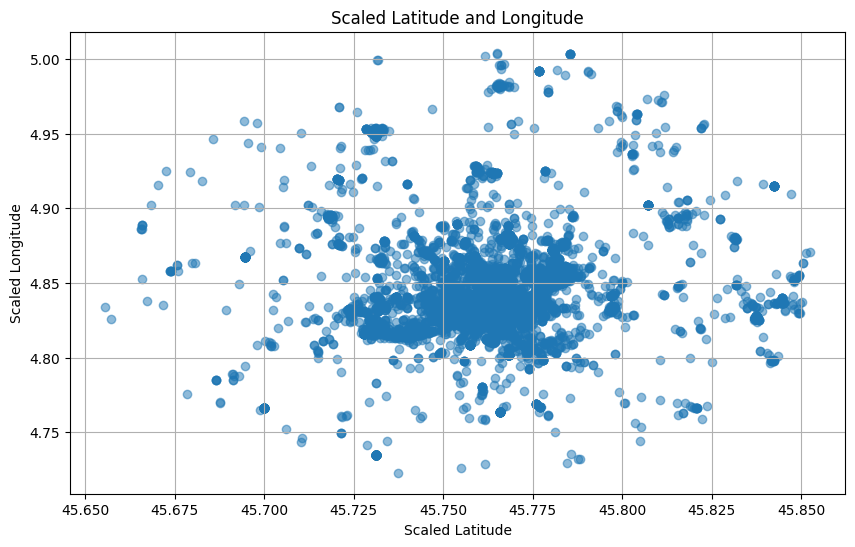

In [21]:
print(len(data_cleaned))

hierarchical = data_cleaned[columns].sample(n=15000, random_state=1).copy()

hierarchical.drop_duplicates()

scaler = StandardScaler()
scaled_hierarchical = scaler.fit_transform(hierarchical)
scaled_hierarchical_df = pd.DataFrame(data=hierarchical, columns=data_cleaned.columns)



plt.figure(figsize=(10, 6))
plt.scatter(scaled_hierarchical_df['lat'], scaled_hierarchical_df['long'], alpha=0.5)
plt.title('Scaled Latitude and Longitude')
plt.xlabel('Scaled Latitude')
plt.ylabel('Scaled Longitude')
plt.grid(True)
plt.show()


In [22]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=70)
clusterh = hierarchical_cluster.fit_predict(scaled_hierarchical)
hierarchical['cluster_hscan'] = clusterh

In [23]:
# Créer une carte centrée sur la moyenne des coordonnées


m = folium.Map(location=[hierarchical['lat'].mean(), hierarchical['long'].mean()], zoom_start=12)

# Filtrer les clusters valides (exclure le bruit: cluster -1)
valid_clusters = hierarchical['cluster_hscan'][hierarchical['cluster_hscan'] != -1].unique()
palette = sns.color_palette("hsv", n_colors=len(valid_clusters))
colors = {cluster: mcolors.rgb2hex(color) for cluster, color in zip(valid_clusters, palette)}



# Ajouter les points de clusters à la carte
for i, row in hierarchical.iterrows():
    cluster_id = row['cluster_hscan']
    if cluster_id == -1:  # Ignorer le bruit
        continue
    folium.CircleMarker(
        location=(row['lat'], row['long']),
        radius=1,
        color=colors[cluster_id],
        fill=True,
        fill_color=colors[cluster_id]
    ).add_to(m)

# Calculer les barycentres des clusters pour les représenter comme "centroïdes"
for cluster_id in valid_clusters:
    cluster_points = hierarchical[hierarchical['cluster_hscan'] == cluster_id][['lat', 'long']].values
    
    if len(cluster_points) == 0:
        continue
    
    # Barycentre du cluster
    centroid = cluster_points.mean(axis=0)
    
    # Ajouter un marqueur pour le barycentre
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Cluster {cluster_id}',
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

    



# Sauvegarder la carte
m.save("../html/hierarchical2.html")

## DBSCAN

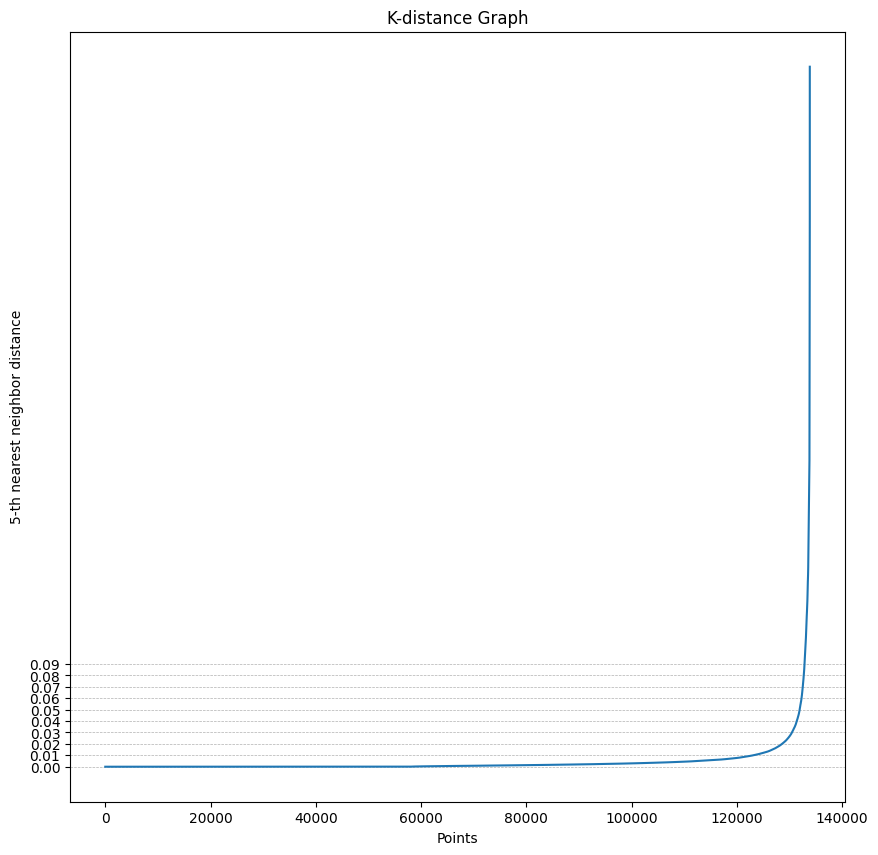

In [24]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 10))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')

    y_min, y_max = 0, 0.1
    y_ticks = np.arange(y_min, y_max, 0.01)  # Création des ticks de 0.001 en 0.001
    plt.yticks(y_ticks)
    plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
    plt.show()
# Plot k-distance graph
plot_k_distance_graph(scaled_data_df, k=5)

In [25]:
features = data_cleaned[['lat','long','tags', 'title']].copy()

In [26]:
print(len(features))
print(len(features))
# Normalisation des données complètes
sample_dbscan= features.sample(n=40000, random_state=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sample_dbscan[columns])

# Appliquer DBSCAN
dbscan = DBSCAN(eps=0.0125, min_samples=90)
clusters = dbscan.fit_predict(scaled_features)

# Ajouter les clusters aux données
sample_dbscan['cluster_dbscan'] = clusters
print(len(features))
#data_cleaned['cluster_dbscan'] = clusters
# Afficher la distribution des clusters


133877
133877
133877


In [27]:


m = folium.Map(location=[sample_dbscan['lat'].mean(), sample_dbscan['long'].mean()], zoom_start=12)

# Filtrer les clusters valides (exclure le bruit: cluster -1)
valid_clusters = sample_dbscan['cluster_dbscan'][sample_dbscan['cluster_dbscan'] != -1].unique()
palette = sns.color_palette("hsv", n_colors=len(valid_clusters))
colors = {cluster: mcolors.rgb2hex(color) for cluster, color in zip(valid_clusters, palette)}

print(len(valid_clusters))
print (len(sample_dbscan))

# Ajouter les points de clusters à la carte
for i, row in sample_dbscan.iterrows():
    cluster_id = row['cluster_dbscan']
    if cluster_id == -1:  # Ignorer le bruit
        continue
    folium.CircleMarker(
        location=(row['lat'], row['long']),
        radius=1,
        color=colors[cluster_id],
        fill=True,
        fill_color=colors[cluster_id]
    ).add_to(m)
 

# Calculer les barycentres des clusters pour les représenter comme "centroïdes"

for cluster_id in valid_clusters:
    cluster_points = sample_dbscan[sample_dbscan['cluster_dbscan'] == cluster_id][['lat', 'long']].values
    
    if len(cluster_points) == 0:
        continue
    
    # Barycentre du cluster
    centroid = cluster_points.mean(axis=0)
    
    # Ajouter un marqueur pour le barycentre
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=f'Cluster {cluster_id}',
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

    # Dessiner l'enveloppe convexe si au moins 3 points
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            folium.Polygon(
                locations=hull_points,
                color=colors[cluster_id],
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
           
        except QhullError:
            print(f"Skipping cluster {cluster_id} due to QhullError")
    



# Sauvegarder la carte
m.save("../html/dbscan_map.html")

35
40000
Skipping cluster 8 due to QhullError
Skipping cluster 9 due to QhullError
Skipping cluster 10 due to QhullError
Skipping cluster 14 due to QhullError
Skipping cluster 29 due to QhullError


## Text mining

### Preprocessing

In [28]:
import nltk
import re
from nltk.corpus import stopwords


# Ensure NLTK stopwords are downloaded.
nltk.download('stopwords')

# Combine English and French stopwords.
stopwords_en = set(stopwords.words('english'))
stopwords_fr = set(stopwords.words('french'))
all_stopwords = stopwords_en.union(stopwords_fr)

def clean_tags(tag_string, words_to_remove):
    """
    Processes a comma-separated string of tags:
      - Splits the string on commas.
      - Removes any tag that is a stopword, contains a digit, or is in the custom removal list.
      - Returns the cleaned tags as a comma-separated string.
    """
    # Split the string on commas and remove extra whitespace.
    raw_tags = [tag.strip() for tag in tag_string.split(',') if tag.strip()]
    processed_tags = []
    
    for tag in raw_tags:
        # Remove all internal whitespace
        tag = re.sub(r'\s+', '', tag)
        
        # Special handling: if the tag starts with "uploaded:by=",
        # then remove that prefix and keep only the value (e.g., "instagram").
        if tag.lower().startswith("uploaded:by="):
            tag = tag[len("uploaded:by="):]
        
        processed_tags.append(tag)
    
    # Filter out tags that are stopwords, contain digits, or are in the additional removal list.
    filtered_tags = [
        tag for tag in processed_tags
        if tag.lower() not in all_stopwords
           and not re.search(r'\d', tag)
           and tag.lower() not in words_to_remove
    ]
    
    return ','.join(filtered_tags)

def clean_titles(title_string, words_to_remove):
    """
    Processes a title string:
      - Splits the title on whitespace.
      - Removes any word that is a stopword, contains a digit, or is in the custom removal list.
      - Returns the cleaned title as a space-separated string.
    """
    words = [word.strip() for word in title_string.split() if word.strip()]
    filtered_words = [
        word for word in words
        if word.lower() not in all_stopwords
           and not re.search(r'\d', word)
           and word.lower() not in words_to_remove
    ]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jassirhabba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
words_to_remove = {'iphone', 'iphonex', 'instagram', 'upload', 'rhone', 
                    'rhonealpes', 'lyon', 'france', 'rhônealpes'}


if 'tags' in sample_dbscan.columns:
    sample_dbscan['tags'] = sample_dbscan['tags'].apply(
        lambda x: clean_tags(x, words_to_remove) if isinstance(x, str) else x
    )
    # Remove rows where 'tags' becomes empty after cleaning.
    sample_dbscan = sample_dbscan.dropna(subset=['tags'])
    sample_dbscan = sample_dbscan[sample_dbscan['tags'].str.strip() != '']

if 'title' in sample_dbscan.columns:
    sample_dbscan['title'] = sample_dbscan['title'].apply(
        lambda x: clean_tags(x, words_to_remove) if isinstance(x, str) else x
    )
    # Remove rows where 'titles' becomes empty after cleaning.
    sample_dbscan = sample_dbscan.dropna(subset=['title'])
    sample_dbscan = sample_dbscan[sample_dbscan['title'].str.strip() != '']

sample_dbscan.to_csv("../data/text-mining.csv", index=False)
print("Data exported to 'text-mining.csv'")

Data exported to 'text-mining.csv'


### Word Cloud Visualisation Tags

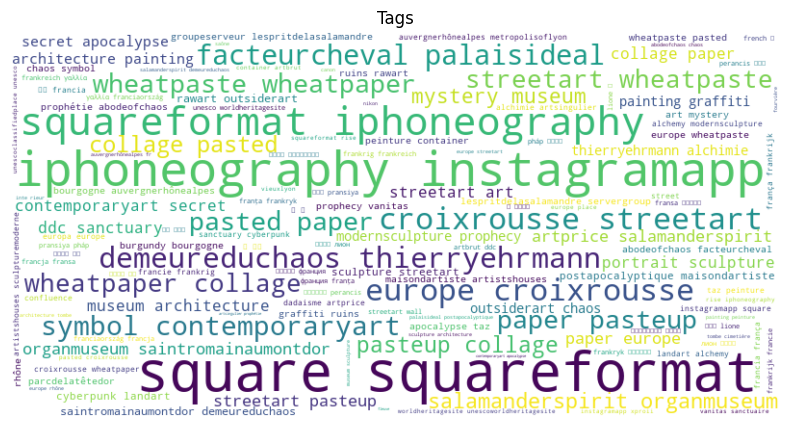

In [30]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

all_tags = ' '.join(sample_dbscan['tags'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tags')
plt.show()


We could not that some text are not relevant for tagging purposes, ie. instagramapp, square, squareformat, etc.
We could then proceed to remove some more data.

In [31]:
words_to_remove = {'square', 'squareformat', 'instagramapp', 'uploaded', 'iphoneography', 'europe', 'rhône'}


if 'tags' in sample_dbscan.columns:
    sample_dbscan['tags'] = sample_dbscan['tags'].apply(
        lambda x: clean_tags(x, words_to_remove) if isinstance(x, str) else x
    )
    # Remove rows where 'tags' becomes empty after cleaning.
    sample_dbscan = sample_dbscan.dropna(subset=['tags'])
    sample_dbscan = sample_dbscan[sample_dbscan['tags'].str.strip() != '']


We then revisualise again, these procedure can be done iteratively.

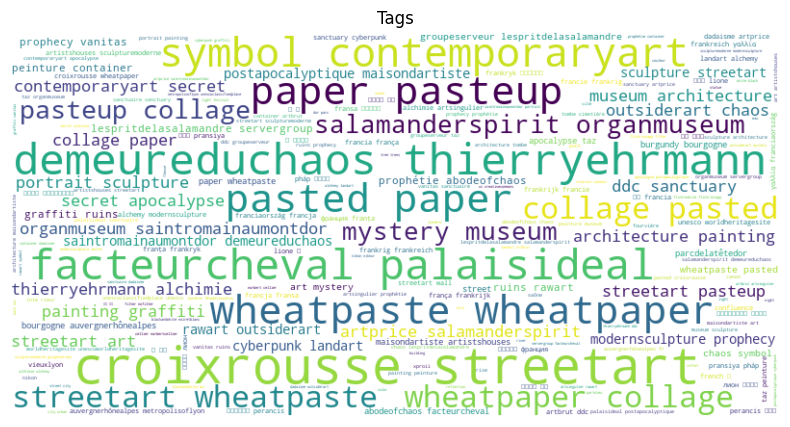

In [32]:
all_tags = ' '.join(sample_dbscan['tags'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tags')
plt.show()

## Term frequency and inverse document frequency (TF-IDF)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_cluster_top_terms(cluster_id, data, cluster_col='cluster_kmeans', text_col='tags', top_n=10):
    """
    Pour un cluster donné, cette fonction :
      - Filtre les lignes du DataFrame pour ce cluster.
      - Agrège le contenu textuel de la colonne spécifiée (par exemple, 'tags').
      - Calcule la TF-IDF en utilisant les stopwords français.
      - Retourne une liste des top_n termes triés par leur score TF-IDF.
    
    Parameters:
        cluster_id : Identifiant du cluster.
        data       : DataFrame contenant les données.
        cluster_col: Nom de la colonne contenant les labels de cluster.
        text_col   : Nom de la colonne contenant le texte.
        top_n      : Nombre de termes à extraire.
    
    Returns:
        list: Liste des top_n termes pour le cluster.
    """
    cluster_data = data[data[cluster_col] == cluster_id]
    if cluster_data.empty:
        return []
    
    aggregated_text = " ".join(cluster_data[text_col].astype(str).tolist())
    
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([aggregated_text])
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray().flatten()
    
    if len(scores) < top_n:
        top_n = len(scores)
    top_indices = scores.argsort()[-top_n:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    
    return top_terms


In [34]:
unique_clusters = sorted(data_cleaned['cluster_kmeans'].unique()) # For cluster kmeans

for cluster_id in unique_clusters:
    terms = get_cluster_top_terms(cluster_id, data_cleaned, cluster_col='cluster_kmeans', text_col='tags', top_n=10)
    print(f"Top terms for cluster {cluster_id}: {terms}")

Top terms for cluster 0: ['comitérhône', 'unicefrhône', 'unicef', 'ong', 'nan', 'lyon', 'france', 'building', 'tour', 'incity']
Top terms for cluster 1: ['demeureduchaos', 'abodeofchaos', 'thierryehrmann', '999', 'alchemy', 'prophecy', 'contemporaryart', 'france', 'organmuseum', 'symbol']
Top terms for cluster 2: ['lyon', 'france', 'nan', 'fourvière', 'europe', 'basilique', 'rhône', 'fourviere', 'rhônealpes', 'basilica']
Top terms for cluster 3: ['lyon', 'japan', 'touch', 'convention', 'decembre', 'japantouch', 'epoquauto', '30', '2013', '01']
Top terms for cluster 4: ['nan', 'francheville', 'chaponost', 'champs', 'lyonnais', 'photo', 'shooting', 'tag', 'tags', 'bâtiment']
Top terms for cluster 5: ['nan', 'lyon', 'france', 'lou', 'rugby', 'tonygarnier', 'mural', 'rhône', 'rhônealpes', 'uploaded']
Top terms for cluster 6: ['lyon', 'nan', 'france', 'street', 'gerland', 'streetart', 'graffiti', 'art', '7ème', 'festival']
Top terms for cluster 7: ['lyon', 'parcdelatêtedor', 'france', 'nan'

## Events

We first define the events for Lyon in a dictionary, this dictionary can of course be expanded further but for the sake of simplicity, we've reduced to some of the major events in Lyon.

In [35]:
events_in_lyon = {
    "Fête des Lumières": {year: ((12, 8), (12, 11)) for year in range(2005, 2020)},
    "Nuits Sonores": {
        2005: ((5, 12), (5, 14)),
        2006: ((5, 11), (5, 13)),
        2007: ((5, 10), (5, 12)),
        2008: ((5, 10), (5, 12)),
        2009: ((5, 9),  (5, 11)),
        2010: ((5, 9),  (5, 11)),
        2011: ((5, 9),  (5, 11)),
        2012: ((5, 9),  (5, 11)),
        2013: ((5, 9),  (5, 11)),
        2014: ((5, 9),  (5, 11)),
        2015: ((5, 9),  (5, 11)),
        2016: ((5, 9),  (5, 11)),
        2017: ((5, 9),  (5, 11)),
        2018: ((5, 9),  (5, 11)),
        2019: ((5, 9),  (5, 11))
    },
    "Fête de la Musique": {year: ((6, 21), (6, 21)) for year in range(2005, 2020)},
    "Les Nuits de Fourvière": {year: ((7, 1), (7, 15)) for year in range(2005, 2020)}
}

We first construct a datetime column from the year, month, and day columns by extracting the corresponding day-of-year and year (filtered to 2005–2019). 

Then, we aggregates the daily photo counts and applies a 7-day rolling mean to smooth out short-term fluctuations — this period is chosen because it captures a full week’s activity, which helps reveal underlying trends and recurring patterns while reducing noise.

We then use peak detection (based on the 90th percentile threshold) to identify days with unusually high photo counts.

Years considered: [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]


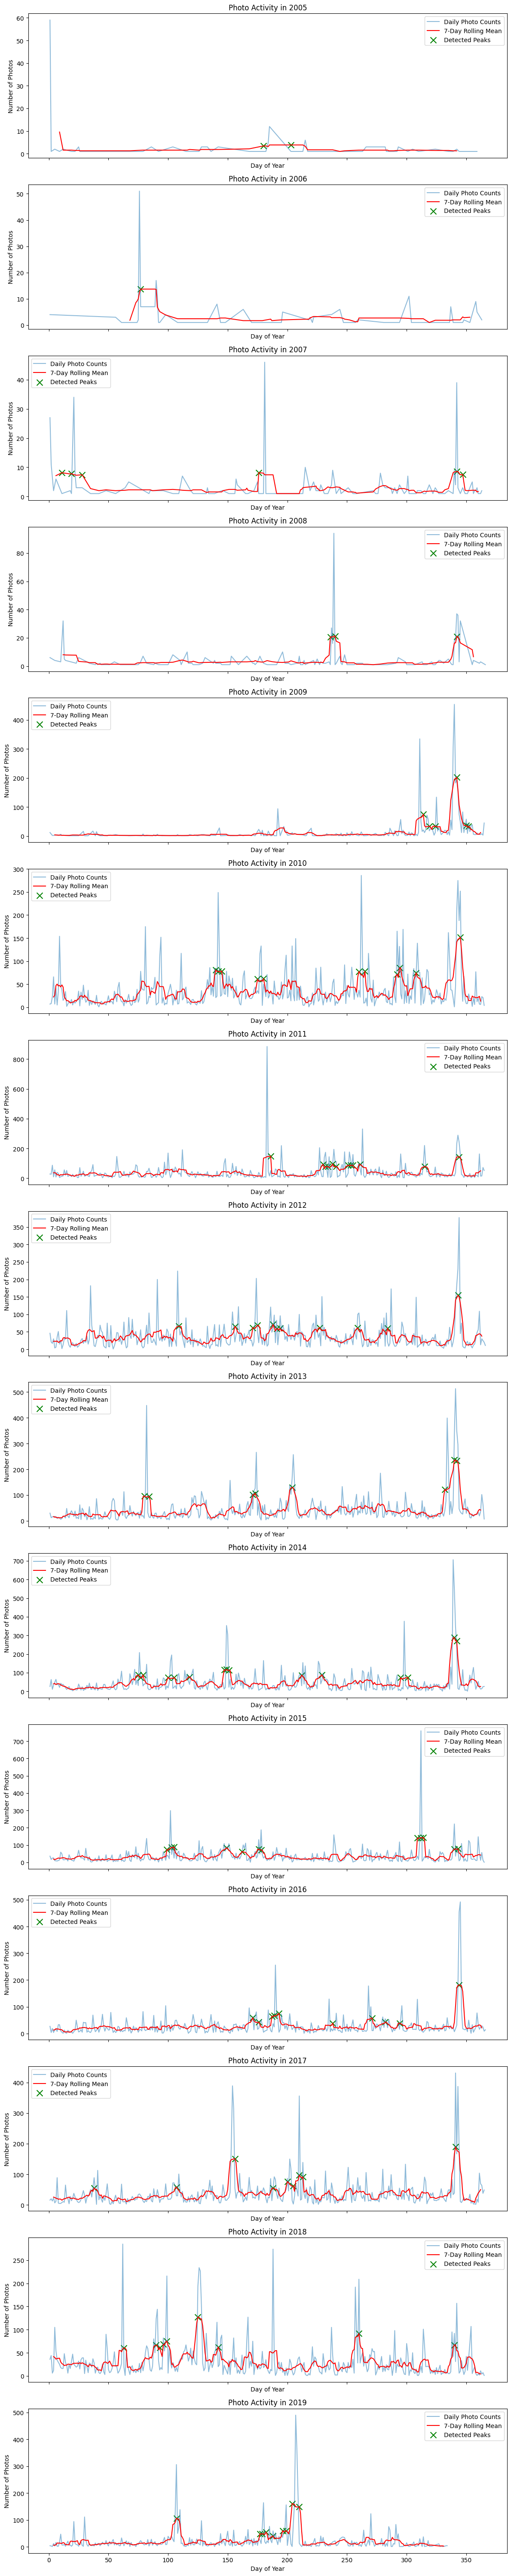

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import datetime
import os

def event_from_day_of_year(day_of_year, reference_year):
    """
    Convert a day-of-year (1-366) into a (month, day) tuple using the given reference year,
    then check if it falls within any known event date ranges for that year.
    """
    dt = datetime.datetime(reference_year, 1, 1) + datetime.timedelta(days=day_of_year - 1)
    current_month, current_day = dt.month, dt.day
    for event, event_dates in events_in_lyon.items():
        # If event_dates is a dict, look up the range for the reference_year.
        if isinstance(event_dates, dict):
            if reference_year in event_dates:
                (start_month, start_day), (end_month, end_day) = event_dates[reference_year]
            else:
                continue  # No date info for this event in this year.
        else:
            (start_month, start_day), (end_month, end_day) = event_dates
        start_dt = datetime.datetime(reference_year, start_month, start_day)
        end_dt = datetime.datetime(reference_year, end_month, end_day)
        if start_dt <= dt <= end_dt:
            return event
    return None


# Create a datetime column using the year, month, and day columns
data_cleaned['date_taken'] = pd.to_datetime(
    data_cleaned['date_taken_year'].astype(str) + '-' +
    data_cleaned['date_taken_month'].astype(str) + '-' +
    data_cleaned['date_taken_day'].astype(str),
    errors='coerce'
)

# Use the provided year column
data_cleaned['year'] = data_cleaned['date_taken_year']
data_cleaned['day_of_year'] = data_cleaned['date_taken'].dt.dayofyear

years = sorted([y for y in data_cleaned['year'].dropna().unique() if 2005 <= y <= 2019]) # Limit to 2005-2019
print("Years considered:", years)

n_years = len(years)
fig, axes = plt.subplots(n_years, 1, figsize=(12, 4 * n_years), sharex=True)
if n_years == 1:
    axes = [axes]

peak_info = {}  # To store detected peaks and associated events for each year

for i, yr in enumerate(years):
    yearly_data = data_cleaned[data_cleaned['year'] == yr]
    # Compute daily photo counts by day-of-year
    daily_counts = yearly_data.groupby('day_of_year').size()
    
    # Apply a 7-day rolling mean to smooth the counts
    daily_counts_smoothed = daily_counts.rolling(window=7, center=True).mean()
    
    # Work only with non-NaN values
    smoothed = daily_counts_smoothed.dropna()
    
    if smoothed.empty:
        print(f"No data available for year {yr}")
        ax = axes[i]
        ax.set_title(f"Photo Activity in {yr} (No Data)")
        continue
    
    # Detect peaks above the 90th percentile threshold
    threshold = np.percentile(smoothed, 90)
    peaks, properties = find_peaks(smoothed, height=threshold)
    
    # Use an empty list if no peaks are detected
    if len(peaks) == 0:
        detected_peak_days = []
    else:
        detected_peak_days = smoothed.index[peaks]
    
    # Associate each detected peak with a known event for that year
    peak_events = {}
    for peak_day in detected_peak_days:
        ev = event_from_day_of_year(peak_day, int(yr))
        peak_events[peak_day] = ev
    peak_info[yr] = peak_events
    
    ax = axes[i]
    ax.plot(daily_counts.index, daily_counts, label='Daily Photo Counts', alpha=0.5)
    ax.plot(smoothed.index, smoothed, label='7-Day Rolling Mean', color='red')
    if len(peaks) > 0:
        ax.scatter(smoothed.index[peaks], smoothed.iloc[peaks], 
                   color='green', marker='x', s=100, label='Detected Peaks')
    ax.set_title(f"Photo Activity in {yr}")
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Number of Photos")
    ax.legend()

plt.tight_layout()
plt.show()

These peaks can then be mapped to the dictionary defined earlier. An export of matching events can be found in output folder.

In [37]:
import os
import datetime

for yr in years:
    printed_any = False
    for peak_day, event in peak_info.get(yr, {}).items():
        if event is not None:
            dt = datetime.datetime(int(yr), 1, 1) + datetime.timedelta(days=peak_day - 1)
            date_str = dt.strftime("%B %d")  # e.g., "December 09"
            print(f"Year {yr} - Day {peak_day} ({date_str}) -> {event}")
            printed_any = True
    if not printed_any:
        print(f"Year {yr}: No matching events")

output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)
events_list = []
for yr in years:
    for peak_day, event in peak_info.get(yr, {}).items():
        if event is not None:  # Only export if there's a matching event
            dt = datetime.datetime(int(yr), 1, 1) + datetime.timedelta(days=peak_day - 1)
            date_str = dt.strftime("%Y-%m-%d")
            events_list.append({
                "year": yr,
                "day_of_year": peak_day,
                "date": date_str,
                "event": event
            })

events_df = pd.DataFrame(events_list)
output_path = os.path.join(output_dir, "events.csv")
events_df.to_csv(output_path, index=False)
print(f"Event data exported to {output_path}")


Year 2005: No matching events
Year 2006: No matching events
Year 2007 - Day 342 (December 08) -> Fête des Lumières
Year 2008: No matching events
Year 2009 - Day 342 (December 08) -> Fête des Lumières
Year 2010 - Day 345 (December 11) -> Fête des Lumières
Year 2011 - Day 186 (July 05) -> Les Nuits de Fourvière
Year 2011 - Day 344 (December 10) -> Fête des Lumières
Year 2012 - Day 188 (July 06) -> Les Nuits de Fourvière
Year 2012 - Day 191 (July 09) -> Les Nuits de Fourvière
Year 2012 - Day 194 (July 12) -> Les Nuits de Fourvière
Year 2012 - Day 343 (December 08) -> Fête des Lumières
Year 2013 - Day 342 (December 08) -> Fête des Lumières
Year 2014 - Day 342 (December 08) -> Fête des Lumières
Year 2015 - Day 343 (December 09) -> Fête des Lumières
Year 2016 - Day 187 (July 05) -> Les Nuits de Fourvière
Year 2016 - Day 189 (July 07) -> Les Nuits de Fourvière
Year 2016 - Day 193 (July 11) -> Les Nuits de Fourvière
Year 2016 - Day 344 (December 09) -> Fête des Lumières
Year 2017 - Day 188 (Ju

We can then conclude that the peaks of photo taken can be justified with events taking places at Lyon, especially Fête des Lumières.

## Final Visualisation using DBSCAN

To make it interesting, we've added here a functionality to calculate a suggestion of path to visit for Lyon.

In [38]:

def gen_destination(number_of_points, features):
    """
    Sélectionne aléatoirement un nombre donné de centroïdes à partir des clusters DBSCAN.
    
    :param number_of_points: Nombre de centroïdes à sélectionner.
    :param features: DataFrame contenant les données avec la colonne 'cluster_dbscan'.
    :return: Numpy array des centroïdes sélectionnés.
    """
    clusters = [c for c in features['cluster_dbscan'].unique() if c != -1]  # Exclure les outliers (-1)
    features =features[['lat','long','cluster_dbscan']].copy()
    if not clusters:
        raise ValueError("Aucun cluster valide trouvé dans les données.")

    cluster_centroids = []
    
    for cluster in clusters:
        cluster_data = features[features['cluster_dbscan'] == cluster].drop(columns=['cluster_dbscan'])
        cluster
        
        centroid = cluster_data.mean().to_numpy()
        cluster_centroids.append(centroid)

    # Vérification du nombre de points demandés
    max_points = len(cluster_centroids)
    if number_of_points > max_points:
        raise ValueError(f"Le nombre de points demandés ({number_of_points}) est supérieur au nombre de clusters disponibles ({max_points}).")

    # Sélectionner aléatoirement le nombre de points demandés
    selected_centroids = random.sample(cluster_centroids, number_of_points)

    return np.array(selected_centroids)


# Exemple d'utilisation
nbr = int(input("Enter the number of destinations you want to visit: "))
destination = gen_destination(nbr, sample_dbscan)
print(destination)


[[45.76432075  4.83588625]
 [45.76593325  4.82729996]
 [45.75977735  4.81975048]
 [45.760538    4.8335298 ]
 [45.76474337  4.8334303 ]]


In [39]:
def tsp_solver_brute_force(points):
    """
    Résolution exacte du TSP avec une approche brute-force (permutation de tous les chemins possibles).
    
    :param points: Numpy array des coordonnées des points.
    :return: Numpy array des coordonnées des points dans l'ordre optimal.
    """
    num_points = len(points)
    if num_points <= 1:
        return points
    
    distance_matrix = cdist(points, points, metric='euclidean')  # Matrice des distances
    
    best_route = None
    best_distance = float('inf')
    
    for perm in permutations(range(num_points)):  # Générer toutes les permutations possibles
        distance = sum(distance_matrix[perm[i], perm[i + 1]] for i in range(num_points - 1))
        if distance < best_distance:
            best_distance = distance
            best_route = perm
    
    return points[np.array(best_route, dtype=int)]  # Retourner les coordonnées dans l'ordre optimal

# Application avec les données fournies
optimized_coordinates_tsp = tsp_solver_brute_force(destination)
print(optimized_coordinates_tsp)

[[45.75977735  4.81975048]
 [45.76593325  4.82729996]
 [45.76474337  4.8334303 ]
 [45.76432075  4.83588625]
 [45.760538    4.8335298 ]]


In [ ]:
import folium
import seaborn as sns
import matplotlib.colors as mcolors
import osmnx as ox
import networkx as nx
from scipy.spatial import ConvexHull, QhullError
from sklearn.feature_extraction.text import TfidfVectorizer

print(sample_dbscan.head())
print(len(sample_dbscan))
# Créer une carte centrée sur la moyenne des coordonnées
map_center = [optimized_coordinates_tsp[:, 0].mean(), optimized_coordinates_tsp[:, 1].mean()]

m = folium.Map(location=[sample_dbscan['lat'].mean(), sample_dbscan['long'].mean()], zoom_start=12)

# Filtrer les clusters valides (exclure le bruit: cluster -1)
valid_clusters = sample_dbscan['cluster_dbscan'][sample_dbscan['cluster_dbscan'] != -1].unique()
palette = sns.color_palette("hsv", n_colors=len(valid_clusters))
colors = {cluster: mcolors.rgb2hex(color) for cluster, color in zip(valid_clusters, palette)}

# Ajouter les points de clusters à la carte
for i, row in sample_dbscan.iterrows():
    cluster_id = row['cluster_dbscan']
    if cluster_id == -1:  # Ignorer le bruit
        continue
    folium.CircleMarker(
        location=(row['lat'], row['long']),
        radius=1,
        color=colors[cluster_id],
        fill=True,
        fill_color=colors[cluster_id]
    ).add_to(m)

# Calculer les barycentres des clusters pour les représenter comme "centroïdes"
for cluster_id in valid_clusters:
    cluster_points = sample_dbscan[sample_dbscan['cluster_dbscan'] == cluster_id][['lat', 'long']].values
    
    if len(cluster_points) == 0:
        continue
    
    # Barycentre du cluster
    centroid = cluster_points.mean(axis=0)
    
    # Récupérer les 10 termes les plus importants
    top_tags = get_cluster_top_terms(cluster_id, sample_dbscan, cluster_col='cluster_dbscan', text_col='tags', top_n=10)
    top_title = get_cluster_top_terms(cluster_id, sample_dbscan, cluster_col='cluster_dbscan', text_col='tags', top_n=1)
    top_tags.pop(0)
    tags_text = "<br>".join(top_tags) if top_tags else "Pas de tags"
    title_text = "<br>".join(top_title) if top_title else "Pas de titre"
    # Ajouter un marqueur pour le barycentre avec les tags
    folium.Marker(
        location=[centroid[0], centroid[1]],
        popup=folium.Popup(f'Cluster {cluster_id}<br><b>{title_text}:</b><br>{tags_text}', max_width=300),
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

    # Dessiner l'enveloppe convexe si au moins 3 points
    if len(cluster_points) >= 3:
        try:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            folium.Polygon(
                locations=hull_points,
                color=colors[cluster_id],
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Skipping cluster {cluster_id} due to QhullError")
    
# Générer le graphe routier
graph = ox.graph_from_point(map_center, dist=5000, network_type='drive')

# Trouver les nœuds les plus proches des points optimisés sur le réseau routier
nearest_nodes = [ox.distance.nearest_nodes(graph, long, lat) for lat, long in optimized_coordinates_tsp]

# Tracer l'itinéraire routier entre les points
route_coords = []
for i in range(len(nearest_nodes) - 1):
    # Calculer le plus court chemin entre les nœuds
    route = nx.shortest_path(graph, nearest_nodes[i], nearest_nodes[i+1], weight="length")
    # Obtenir les coordonnées des routes
    route_coords.extend([(graph.nodes[node]['y'], graph.nodes[node]['x']) for node in route])

# Ajouter la route optimisée sur la carte
folium.PolyLine(
    locations=route_coords,
    color="red",
    weight=2.5,
    opacity=1
).add_to(m)

# Sauvegarder la carte
m.save("../html/dbscan_map2.html")

              lat      long  \
155441  45.776963  4.859417   
70569   45.784531  4.852974   
382923  45.757536  4.833138   
133373  45.767119  4.833544   
92210   45.727356  4.830470   

                                                     tags  \
155441  games,convention,jeu,jeux,roleplayinggames,jeu...   
70569                         art,mac,contemporain,grdiii   
382923  fr,patman,patrickmanoux,nuit,night,graphique,g...   
133373  sculpture,arlequin,muséedesbeauxarts,renédesai...   
92210   music,rock,canon,concert,groupe,musique,specta...   

                                    title  cluster_dbscan  
155441  Octogônes–StanddeKerlaftlerôliste              -1  
70569            MuséeArtContemporainLyon              -1  
382923                            Graphic               3  
133373                         eerilyreal               4  
92210               Wind'sWayAlexàlabasse              -1  
13172
Skipping cluster 10 due to QhullError
Skipping cluster 9 due to QhullError
